# What impacts developers' job expectations? - StackOverflow Survey 2020 Summary

Nowadays, the non-compensation factors arises as the key to hire a succesfull worker. Companies are able to offer enourmous salaries, however it's not the money what often decides of accepting this or that job.

What are these factors? Which of them are the most important and why do seekers and employees found them relevant? Presented notebook aims to find the answer to these questions.
Presented analysis process meets the CRISP-DM requirements and consists of:

1. [Business understanding - this part is covered in this paragraph](#bu) 
1. [Data understanding](#du)
1. [Data preparation](#dp)
1. [Modelling](#m)
1. [Evaluation](#e)

<div id='bu'/>

## 1. Business Understanding part
First of all, let's replace introduced question with some atomic, more precise equivalents. I will start from finding an answer to the easiest one - **What are the top important factors for individuals when seeking job?** It's good to start from some simple tasks that will give the general overview of researched topic.

<b>Then I'm going to get into the core questions:<ol>
    <li>Which factors tends to be chosen together and why?</li>
    <li>Are there any patterns in respondents choices?</li>
    <li>What impact respondents' choices?</li>
</ol></b>    

Finding answers to the questions will allow to fill the knowledge gap of developers' job expectations.

<!--There are also two bonus questions - not related to main topic, nonetheless I found them interesting:
<ul>
    <li>Is there any relationship between survey length opinion, the purple link reaction and the salary?</li>
    <li>Do the overtime affects negatively a job satisfaction?</li>
</ul>
The hypothesis here is that the link reaction could somehow express the general mood of individual when filling the survey. Thinking of negative emotions like overtimes or poor job satisfaction could also express the mood. Let's find it out!-->

<div id='du'/>

## 2. Data understanding
Surveys organised by StackOverflow are a great source of information regarding developers job situation and their expectations. Dataset used in the analysis comes from ***The Public 2020 Stack Overflow Developer Survey Results***, fielded between 5th and 28th of February 2020 on StackOverflow users. The survey results are available on: https://insights.stackoverflow.com/survey. The data collection consists of `README_2020.txt`, containing the purpose and a general description of the research, and other files, described also in README:
> 1. `so_survey_2020.pdf` - PDF file of survey instrument
2. `survey_results_public.csv` - CSV file with main survey results, one respondent per row and one column per answer
3. `survey_results_schema.csv` - CSV file with survey schema, i.e., the questions that correspond to each column name

### 2.1. Prerequsities

In [1]:
## Wrangling
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr

## Visualization
from matplotlib import ticker
from matplotlib.pyplot import Line2D
from matplotlib.patches import Rectangle
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick 
import matplotlib.dates as mdates
import seaborn as sns

## Machine Learning
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
import xgboost as xgb
import shap

## Utils
import networkx as nx
import warnings
from typing import List
from cycler import cycler

In [2]:
## Settings:
# Pandas display & warnings
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('max_colwidth', 100)
warnings.filterwarnings('ignore')

# Constants
DATA_PATH ='data/survey_results_public.csv'
SCHEMA_PATH = 'data/survey_results_schema.csv'
C_GREEN = '#3b936e'
C_RED = '#ee4450'
BARH_FIGURE_PARAMS = {'figsize': (6,6), 'dpi': 72}

FACTORS_SHORTNAMES = {
    'Diversity of the company or organization': 'Diversity', 
    'Family friendliness': 'Family friendliness',
    'Financial performance or funding status of the company or organization': 'Organization finances',
    'Flex time or a flexible schedule': 'Flex time',
    'How widely used or impactful my work output would be': 'Work impact',
    'Industry that I’d be working in': 'Industry',
    'Languages, frameworks, and other technologies I’d be working with': 'Tech stuff',
    'Office environment or company culture': 'Company culture and env.',
    'Opportunities for professional development': 'Professional development', 
    'Remote work options': 'Remote work',
    'Specific department or team I’d be working on':'Specific department'
}

# Matplotlib configuration
COLORS = ['#55587d', C_GREEN, '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
MY_CYCLER = cycler('color', COLORS)  
MY_RCPARAMS = {
    "font.family": "sans-serif",
    "font.sans-serif": 'Verdana',
    "figure.figsize": [12, 4],
    "axes.titlesize": 16,
    "figure.titlesize": 16,
    "ytick.labelsize": 12,
    "xtick.labelsize": 12,
    "axes.grid": True,
    "grid.alpha": 0.5,
    "axes.prop_cycle": MY_CYCLER,
    "figure.figsize": (10,4),
    "figure.titlesize": 16,
}
plt.rcParams.update(MY_RCPARAMS)

In [3]:
# Data loading
data = pd.read_csv(DATA_PATH)
schema = pd.read_csv(SCHEMA_PATH, index_col='Column')
print(data.shape, schema.shape)

(64461, 61) (61, 1)


**Provided dataset consists of 61 columns and exactly 64461 rows**, what matches to information posted in the survey website where it is claimed there is about 65k responses. 

In order to easily explore the features, I provided a simple function that prints the description of the fields that match the provided string:

In [4]:
def question(question: str, return_string=False, exact_match=False):
    """Get feature description(s) from schema based on question or its part.
    
    Parameters:
        - question: str, feature name to be searched in the schema.
        - return_string: Bool, default False, if return output as a string instead of printing it.
        - exact_match: Bool, default False, if search using exact, case sensitive matching.
    """
    
    if return_string and exact_match:
        return schema.at[question, 'QuestionText']
    
    for name in schema.index:
        if question.lower() in name.lower():
            print(f"{name}:\n{schema.at[name, 'QuestionText']}", end='\n\n')
    
question('Webframe') # Example

WebframeDesireNextYear:
Which web frameworks have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)

WebframeWorkedWith:
Which web frameworks have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the framework and want to continue to do so, please check both boxes in that row.)



In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Respondent                    64461 non-null  int64  
 1   MainBranch                    64162 non-null  object 
 2   Hobbyist                      64416 non-null  object 
 3   Age                           45446 non-null  float64
 4   Age1stCode                    57900 non-null  object 
 5   CompFreq                      40069 non-null  object 
 6   CompTotal                     34826 non-null  float64
 7   ConvertedComp                 34756 non-null  float64
 8   Country                       64072 non-null  object 
 9   CurrencyDesc                  45472 non-null  object 
 10  CurrencySymbol                45472 non-null  object 
 11  DatabaseDesireNextYear        44070 non-null  object 
 12  DatabaseWorkedWith            49537 non-null  object 
 13  D

### 2.2 Numeric features

As we can see we have here only a few numeric features.

In [6]:
numerics = list(data.select_dtypes(exclude='object'))
numerics

['Respondent', 'Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs']

In [7]:
for col in numerics: 
    question(col)

Respondent:
Randomized respondent ID number (not in order of survey response time)

Age:
What is your age (in years)? If you prefer not to answer, you may leave this question blank.

Age1stCode:
At what age did you write your first line of code or program? (e.g., webpage, Hello World, Scratch project)

LanguageDesireNextYear:
Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)

LanguageWorkedWith:
Which programming, scripting, and markup languages have you done extensive development work in over the past year, and which do you want to work in over the next year? (If you both worked with the language and want to continue to do so, please check both boxes in that row.)

CompTotal:
What is your current total compensation (salary, bonuses, and perks, before taxes and ded

In [8]:
data.describe()

,Respondent,Age,CompTotal,ConvertedComp,WorkWeekHrs
count,64461.000,45446.000,34826.000,34756.000,41151.000
mean,32554.080,30.834,3190464340180068131588818645558207196692997101831037645396713168789760386172199715519058568532039...,103756.050,40.782
std,18967.442,9.585,inf,226885.296,17.816
min,1.000,1.000,0.000,0.000,1.000
25%,16116.000,24.000,20000.000,24648.000,40.000
50%,32231.000,29.000,63000.000,54049.000,40.000
75%,49142.000,35.000,125000.000,95000.000,44.000
max,65639.000,279.000,1111111111111110488684693855549925290411557051110477897391096070550990898397557569113613423770778...,2000000.000,475.000


The above description as well as following histograms, inform there is some invalid data. For instance, max `Age` equals 279 years and max total compensation (`CompTotal`) seems to be impossible. Note that `CompTotal` should match `ConvertedComp` times exchange rate of given currency (`CurrencySymbol`).

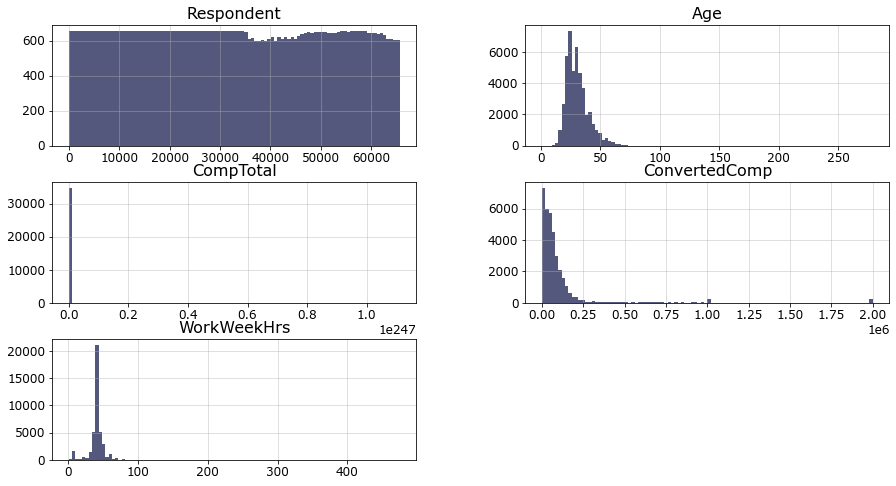

In [9]:
data.hist(figsize=(15,8), bins=100);

Of course, the `Respondent` stands for individual index. We can see, that during the data cleaning performed by Stack Overflow team, some individuals have been excluded. That's why the distribution of the feature is not fully uniform. Well done, at least the dataset is partly cleaned :) Unfortunately, there are some outliers in other numerical fields. Actually that's strange there wasn't any validation provided for those features. If necessary, I'll deal with them later. Let's continue the exploration part.

### 2.3 Non-numeric features

In order to review other features I provided useful plotting function below:

In [10]:
def plot_feature_counts(min_nunique=2, max_nunique=5, colwrap=6, height=3, aspect=1.1):
    """Generate multiple count plots for categorical features based on number of unique values.
    
    Parameters:
        - min_nunique: int, default 2, plot only features having at least min_nunique values
        - max_nunique: int, default 5, plot only features having up to max_nunique values
        - colwrap: int, default 6, 'col_wrap' parameter of sns.FacetGrid
        - height: int, default 3, 'height' parameter of sns.FacetGrid
        - aspect: float, default 1.1, 'aspect' parameter of sns.FacetGrid
    """
    
    # Gather features meetign min_nunique and max_nunique requirements
    feat_to_plot = [feat for feat in data if data[feat].nunique() <= max_nunique and data[feat].nunique() >= min_nunique]
    
    # Adjust data structure to sns.FacetGrid
    data_melted = data[feat_to_plot].fillna('No answer provided').melt() 
    
    # Plot grid
    g = sns.FacetGrid(data_melted, 
                      col='variable', 
                      col_wrap=colwrap, 
                      sharex=False, 
                      height=height, 
                      aspect=aspect)
    
    g.map(sns.countplot, 'value')

    # Unfortunately, it's the only way to rotate the x labels of subplots:
    for ax in g.axes.ravel(): 
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

    plt.subplots_adjust(hspace=2, wspace=0.1)
    g.fig.suptitle(f'Count plot of features having number of unique values between {min_nunique} and {max_nunique}', y=1.05)

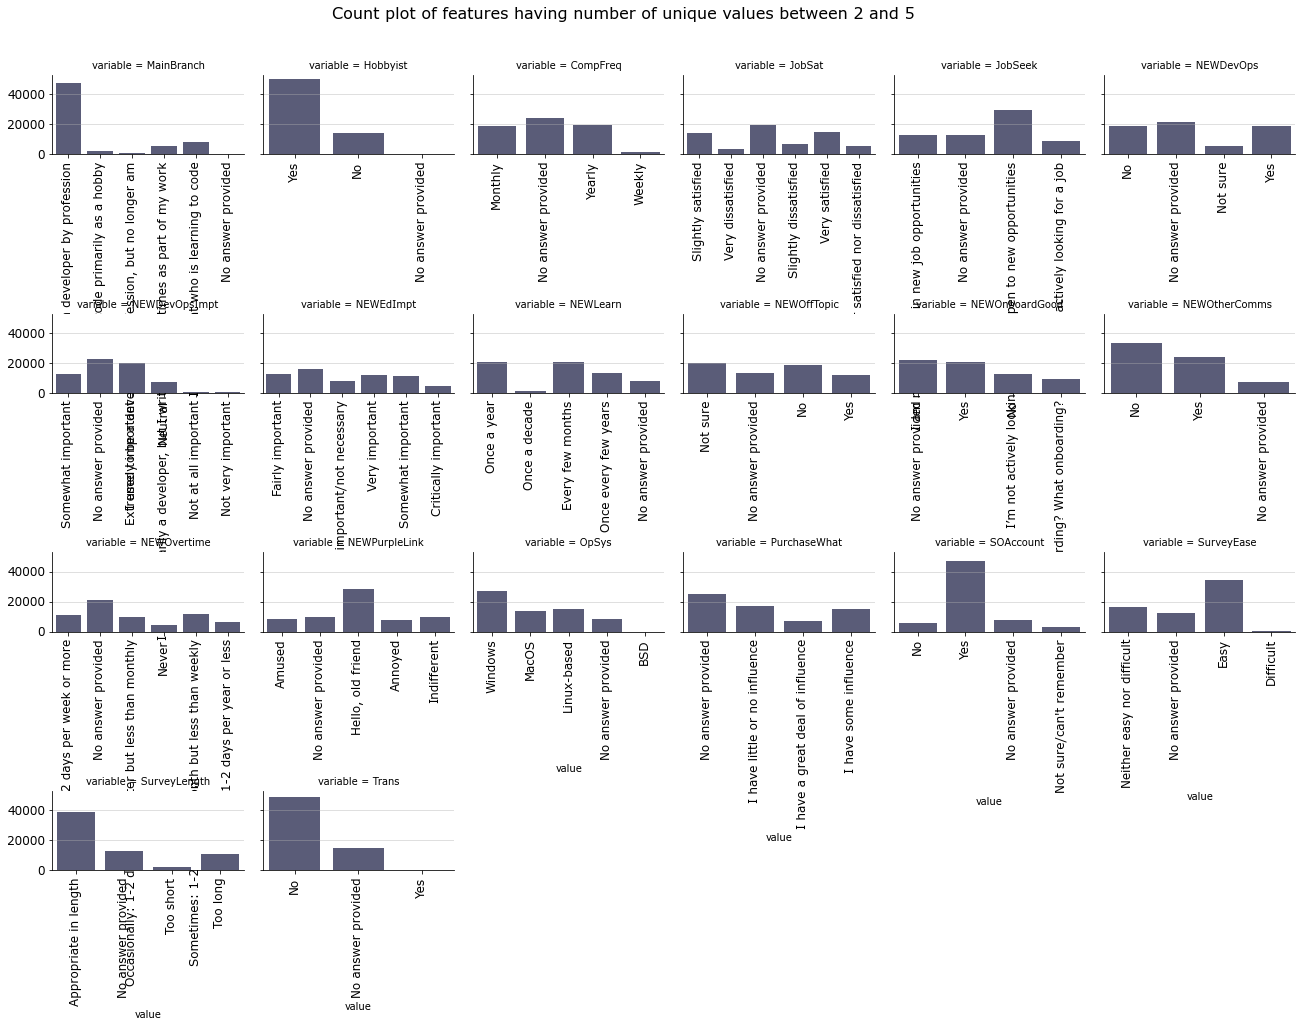

In [11]:
plot_feature_counts()

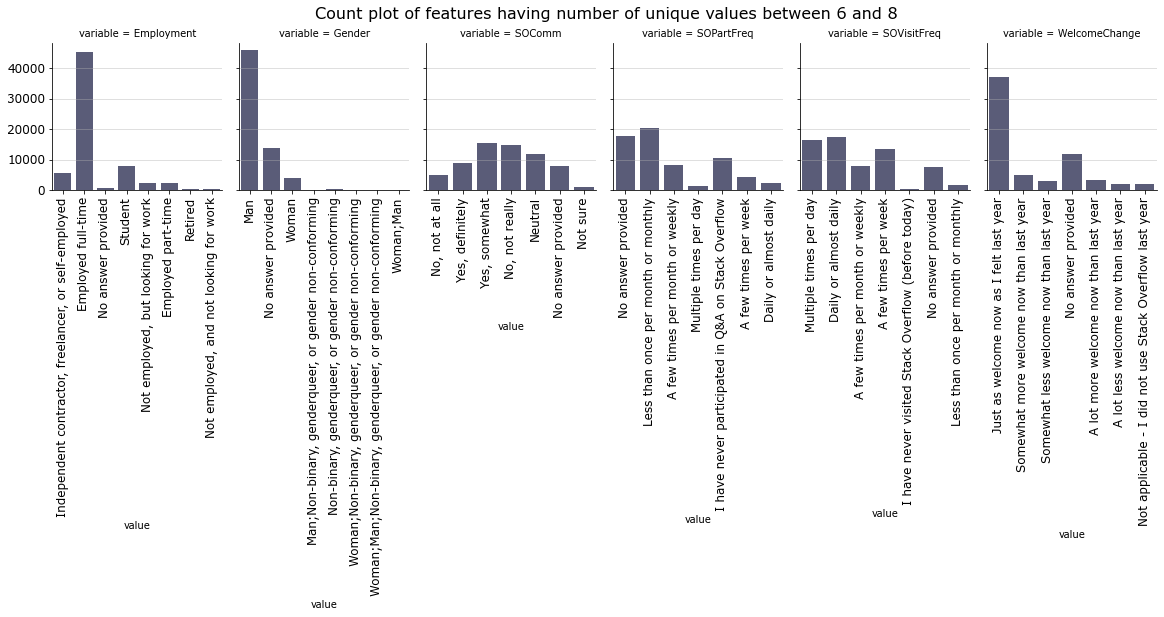

In [12]:
plot_feature_counts(6, 8)

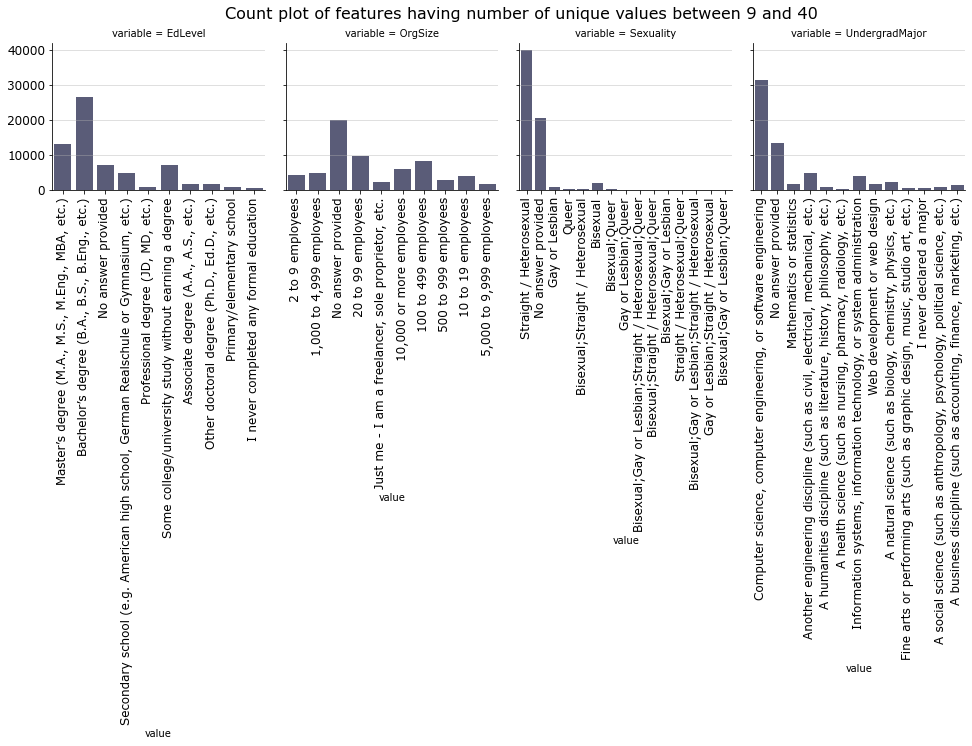

In [13]:
plot_feature_counts(9, 40, aspect=1.5, colwrap=4)

We explored about 35 features so far out of 61. That mean there is 26 features having large number of unique values.

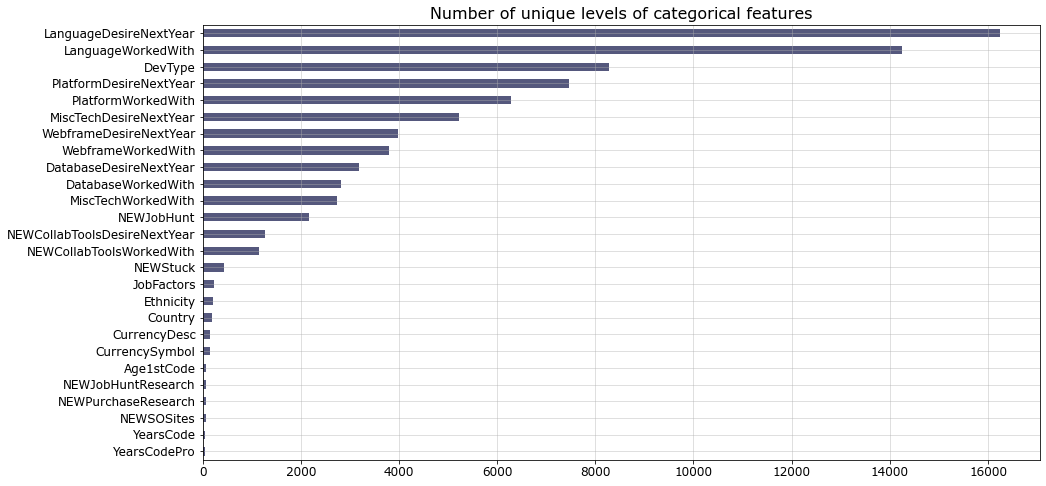

In [14]:
many_nunique_cats = data.select_dtypes('object').nunique().nlargest(26)
many_nunique_cats.sort_values().plot.barh(figsize=(15,8), title='Number of unique levels of categorical features');

In [15]:
data[many_nunique_cats.index].sample(2)

,LanguageDesireNextYear,LanguageWorkedWith,DevType,PlatformDesireNextYear,PlatformWorkedWith,MiscTechDesireNextYear,WebframeDesireNextYear,WebframeWorkedWith,DatabaseDesireNextYear,DatabaseWorkedWith,MiscTechWorkedWith,NEWJobHunt,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWStuck,JobFactors,Ethnicity,Country,CurrencyDesc,CurrencySymbol,Age1stCode,NEWJobHuntResearch,NEWPurchaseResearch,NEWSOSites,YearsCode,YearsCodePro
20701,Go;HTML/CSS;JavaScript;Python;Rust;Scala,C++;Python,"Developer, back-end",Docker;Kubernetes;Linux,Microsoft Azure;Windows,Keras;TensorFlow;Teraform;Torch/PyTorch,Django,Flask,Cassandra;MongoDB,PostgreSQL;Redis;SQLite,Pandas;TensorFlow,Curious about other opportunities;Better compensation;Trouble with my direct manager;Trouble wit...,Confluence;Jira;Microsoft Teams;Trello,Jira;Microsoft Teams;Trello,Call a coworker or friend;Visit Stack Overflow;Do other work and come back later,Flex time or a flexible schedule;Office environment or company culture;Opportunities for profess...,Southeast Asian,India,Indian rupee,INR,10,"Read company media, such as employee blogs or company culture videos;Company reviews from third ...",Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overfl...,Stack Overflow (public Q&A for anyone who codes);Stack Exchange (public Q&A for a variety of top...,8,3
28203,Bash/Shell/PowerShell;C#;Go;Python;SQL;Swift,Bash/Shell/PowerShell;C#;HTML/CSS;JavaScript;PHP;Python;SQL,Engineering manager,AWS;Docker;Heroku;Kubernetes;Linux;MacOS;Microsoft Azure,AWS;Docker;Heroku;Linux;MacOS;WordPress,.NET Core;Puppet;TensorFlow;Teraform,ASP.NET Core;Django;Express;Flask;Vue.js,Express;Flask;jQuery,Cassandra;DynamoDB;MySQL;PostgreSQL;Redis,DynamoDB;Firebase;Microsoft SQL Server;MySQL;PostgreSQL;SQLite,Node.js;Pandas;TensorFlow,Curious about other opportunities;Better work/life balance;Wanting to work with new technologies...,Github;Microsoft Azure,Jira;Github;Microsoft Teams,Go for a walk or other physical activity;Watch help / tutorial videos;Do other work and come bac...,Flex time or a flexible schedule;Remote work options;Office environment or company culture,White or of European descent,United States,United States dollar,USD,17,"Company reviews from third party sites (e.g. Glassdoor, Blind);Personal network - friends or fam...",Start a free trial;Ask developers I know/work with,Stack Overflow (public Q&A for anyone who codes),23,20


As we can see some of these features are actually numeric (`YearsCode`, `YearsCodePro`, `Age1stCode`), however most of them have multiple values stored in a single cell. There are also a few fields having one value per cell and large number of unique values: `Ethicinity`, `Country`, `CurrencyDesc`, `CurrencySymbol`  That's the result of multi-choise questions. **From perspective of the analysis the most important is `JobFactors`:**

### 2.4 JobFactors - the key feature

In [16]:
question('jobfactors')

JobFactors:
Imagine that you are deciding between two job offers with the same compensation, benefits, and location. Of the following factors, which 3 are MOST important to you?



In [17]:
data['JobFactors'].nunique()

230

The field have 230 unique values, however we know it's combination of one of the followings:

![img/survey-job-factors.png](img/survey-job-factors.png)


**On one hand the question describes an imagined situation, on the other hand this could be treated as good explainer of what is important when looking for a job (except salary, location and benefits). This well represents the respondents' job preferences.**

In [18]:
list(data['JobFactors'].unique()[:10])

['Languages, frameworks, and other technologies I’d be working with;Remote work options;Opportunities for professional development',
 nan,
 'Flex time or a flexible schedule;Office environment or company culture;Opportunities for professional development',
 'Diversity of the company or organization;Languages, frameworks, and other technologies I’d be working with;Office environment or company culture',
 'Remote work options;Opportunities for professional development;Family friendliness',
 'Diversity of the company or organization;Remote work options;Office environment or company culture',
 'Flex time or a flexible schedule;How widely used or impactful my work output would be;Opportunities for professional development',
 'Flex time or a flexible schedule;Languages, frameworks, and other technologies I’d be working with;Remote work options',
 'Remote work options;Office environment or company culture;Family friendliness',
 'Industry that I’d be working in;Financial performance or funding

**In order to anwer all of the questions there are many fields that will be used for sure. Among them are: `JobFactors`:  `ConvertedComp`, `Employment`, `JobSat`, `Age`, `OrgSize`, `NEWOvertime`, and many more.**

<!-- `NEWPurpleLink`, `SurveyLength` -->

 <div id='dp'/>

## 3. Data Preparation

Data preparation process is devided into few steps:

1. Handling NULL/NA values

2. Dealing with outliers

3. Breaking down the `JobFactors`

### 3.1 Handling NULL/NA values

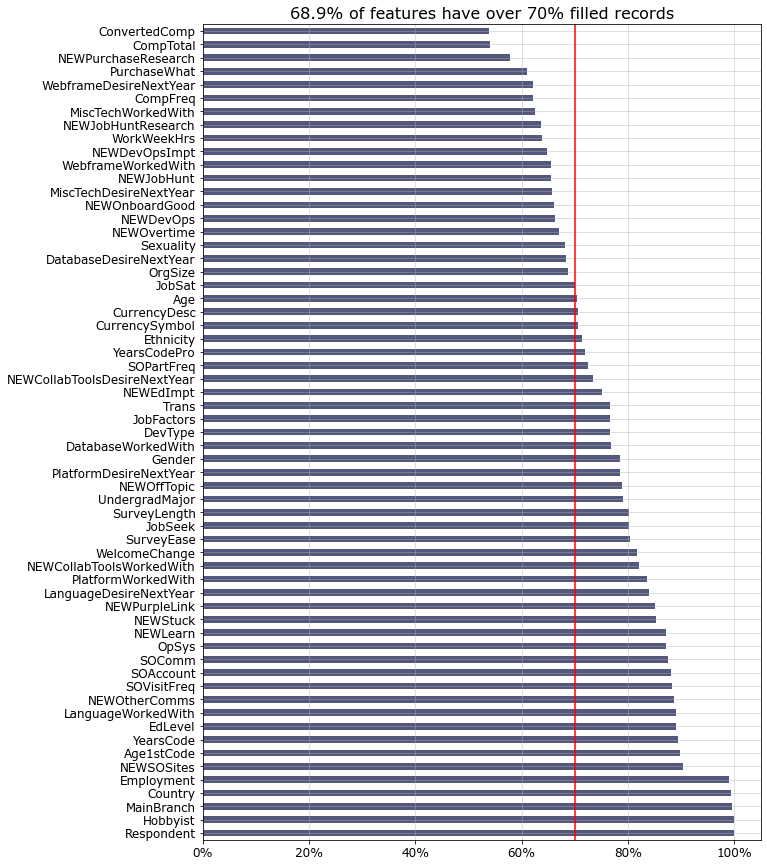

In [19]:
not_na_perc = data.notna().mean()
not_na_over_70 =  (not_na_perc > 0.7).mean() * 100
ax = not_na_perc.sort_values(ascending=False).plot.barh(figsize=(10,15), title=f'{not_na_over_70:.1f}% of features have over 70% filled records');
plt.axvline(x=0.7, color='red')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1));

According to the chart above, **closely 70% of features have over 70% of filled values** what is quite good result. Worth to mention some of them couldn't be filled because of questions specification. 


### Breaking down JobFactors

In [20]:
-1 in data.values or '-1' in data.values # I'll use -1 to temporarely replace NaNs that's why I checked if it exists in dataset.

False

In [21]:
data[['Respondent', 'JobFactors']].head(5) # Take a look before transformation

,Respondent,JobFactors
0,1,"Languages, frameworks, and other technologies I’d be working with;Remote work options;Opportunit..."
1,2,NaN
2,3,NaN
3,4,Flex time or a flexible schedule;Office environment or company culture;Opportunities for profess...
4,5,NaN


In [22]:
jobfactors_split = pd.DataFrame(data.JobFactors.fillna('-1').str.split(';').tolist(), index=data.Respondent)
jobfactors_stack = pd.DataFrame(jobfactors_split.stack()).reset_index().drop('level_1', axis=1).rename({0: 'JobFactors'}, axis=1)
jobfactors_stack.head(9) # Take a look after breaking down

,Respondent,JobFactors
0,1,"Languages, frameworks, and other technologies I’d be working with"
1,1,Remote work options
2,1,Opportunities for professional development
3,2,-1
4,3,-1
5,4,Flex time or a flexible schedule
6,4,Office environment or company culture
7,4,Opportunities for professional development
8,5,-1


In [23]:
data.JobFactors.isna().mean()

0.23443632584043064

In [24]:
(jobfactors_stack.JobFactors == '-1').mean()

0.09454691058334794

Unfortunately ~23% of respondents haven't answered the question. However when we explode the answers and stack them, the NaNs stands for below 10% of answers broken into particular options. Since it's our explained feature, I'll not fill the missing values. Instead, I'm going to drop them.

In [25]:
data.dropna(subset=['JobFactors'], inplace=True)
jobfactors_split = pd.DataFrame(data.JobFactors.str.split(';').tolist(), index=data.Respondent)
jobfactors_stack = pd.DataFrame(jobfactors_split.stack()).reset_index().drop('level_1', axis=1).rename({0: 'JobFactors'}, axis=1)
jobfactors_stack.head(9) # After breaking down

,Respondent,JobFactors
0,1,"Languages, frameworks, and other technologies I’d be working with"
1,1,Remote work options
2,1,Opportunities for professional development
3,4,Flex time or a flexible schedule
4,4,Office environment or company culture
5,4,Opportunities for professional development
6,6,Diversity of the company or organization
7,6,"Languages, frameworks, and other technologies I’d be working with"
8,6,Office environment or company culture


In [26]:
job_factors_stack_counts = jobfactors_stack.JobFactors.value_counts(ascending=True)
job_factors_stack_counts

Diversity of the company or organization                                   3387
Specific department or team I’d be working on                              5805
Financial performance or funding status of the company or organization     5892
Family friendliness                                                        5986
Industry that I’d be working in                                            7574
How widely used or impactful my work output would be                      10277
Remote work options                                                       16411
Opportunities for professional development                                20421
Flex time or a flexible schedule                                          21656
Office environment or company culture                                     21981
Languages, frameworks, and other technologies I’d be working with         25334
Name: JobFactors, dtype: int64

So here we have counts of the **JobFactors**, that is, the most important factors when choosing job offer (non-related to location, money and benefits). Now have an occasion to answer the first, simplest one, question:
##  What are the top important factors for individuals when seeking job?

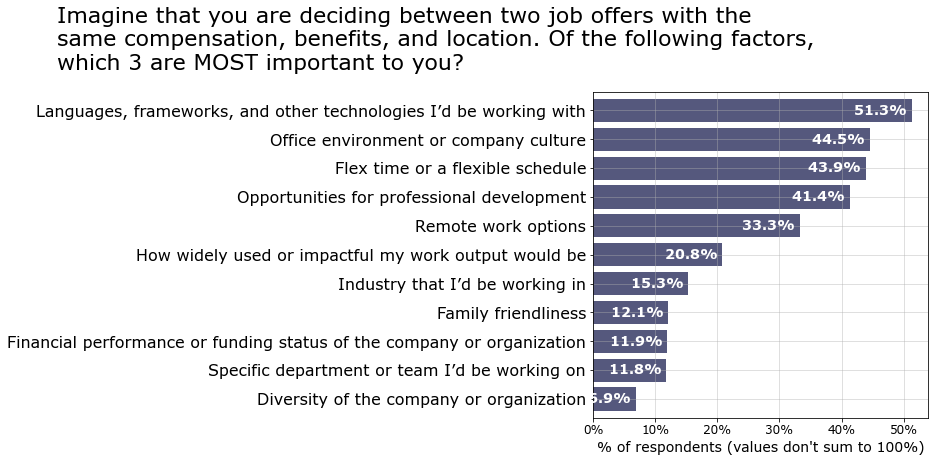

In [27]:
plt.figure(**BARH_FIGURE_PARAMS)
ax = (job_factors_stack_counts / data.shape[0]).plot.barh(width=0.8)

plt.yticks(fontsize=16)
wrap_title = """Imagine that you are deciding between two job offers with the
same compensation, benefits, and location. Of the following factors, 
which 3 are MOST important to you?"""

ax.set_title(wrap_title, fontdict={'fontsize':22}, loc='left', x=-1.6, y=1.05)
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.set_xlabel("% of respondents (values don't sum to 100%)", fontsize=14)
for i, option in enumerate(job_factors_stack_counts.index):
    x = job_factors_stack_counts[option] / data.shape[0]
    ax.annotate(s=f'{x*100:.1f}% ', xy=(x, i), va='center', ha='right', color='white', fontsize=14, weight='bold')


Here we have the answer on the first question:
We can clearly see that **for over 1/2 of respondents, technology is one of the most important factors when deciding on taking job offer**. It shouldn't surprise since nobody would like to work in technology that is not interested in or is not familiared with. 

The second and third place are the **office environment or company culture** and **Flexible schedule**. Similar number of respondents have chosen also the **opportunities for professional development** as the most important factor. And these four emerged as dominant so the most important among others.

On the lower side of the list we have just about 7% of respondents that picked the **diversity of the company or organization** as most important factor when taking a job offer.

Are there any patterns in respondents choises? Maybe some options used to be chosen together? Below there is a contingency table which will help finding answer.

In [28]:
jobfactors_stack.set_index('Respondent', inplace=True)

In [29]:
# Generate contingency table:
out = dict()
for option in jobfactors_stack.JobFactors.unique():

    considered = jobfactors_stack.query('JobFactors == @option')
    corresponds = jobfactors_stack.query('JobFactors != @option')

    con_ind = set(considered.index)
    cor_ind = set(corresponds.index)
    common_ind = con_ind.intersection(cor_ind)
    
    out[option] = corresponds.loc[common_ind].JobFactors.value_counts()

df_out = pd.DataFrame.from_dict(out).sort_index()
df_out = df_out[df_out.index]

cm = sns.light_palette("green", as_cmap=True)
df_out.style.background_gradient(cmap=cm, axis=0).set_precision(0)

,Diversity of the company or organization,Family friendliness,Financial performance or funding status of the company or organization,Flex time or a flexible schedule,How widely used or impactful my work output would be,Industry that I’d be working in,"Languages, frameworks, and other technologies I’d be working with",Office environment or company culture,Opportunities for professional development,Remote work options,Specific department or team I’d be working on
Diversity of the company or organization,nan,282,215,881,582,391,1004,1337,1003,729,243
Family friendliness,282,nan,513,2236,655,472,1875,1917,1652,1678,374
Financial performance or funding status of the company or organization,215,513,nan,1616,787,577,2298,1921,1953,1275,416
Flex time or a flexible schedule,881,2236,1616,nan,2601,1927,9357,8084,6499,8096,1480
How widely used or impactful my work output would be,582,655,787,2601,nan,1470,3979,3640,3728,1857,980
Industry that I’d be working in,391,472,577,1927,1470,nan,3107,2507,2251,1463,751
"Languages, frameworks, and other technologies I’d be working with",1004,1875,2298,9357,3979,3107,nan,9813,8746,7242,2448
Office environment or company culture,1337,1917,1921,8084,3640,2507,9813,nan,7914,4296,2059
Opportunities for professional development,1003,1652,1953,6499,3728,2251,8746,7914,nan,4641,1767
Remote work options,729,1678,1275,8096,1857,1463,7242,4296,4641,nan,902


Above table doesn't really answer our question since it contains absolute values. It's obvious the most popular factors would be the most popular second choise for almost all of the options. I'm looking for more sophisticated relations. I would like to answer to questions like: what is the most common choice for respondents that have chosen "Diversity" as important factor?

In [30]:
job_factors_counts = pd.DataFrame(jobfactors_stack.JobFactors.value_counts(ascending=True))
counts = pd.concat([job_factors_counts for i in range(11)], axis=1).sort_index()
counts.columns = counts.index

Before I'll answer, I'm going to simplify the factors names for sake of visibility:

In [31]:
rel_counts = (df_out / counts * 100)

# changing indexes and columns names:
rel_counts = rel_counts.reset_index()
rel_counts['index'].replace(FACTORS_SHORTNAMES, inplace=True)
rel_counts.set_index('index', inplace=True)
rel_counts.columns = [FACTORS_SHORTNAMES[col] for col in rel_counts.columns]

In [32]:
rel_counts.style.background_gradient(cmap=cm, axis=0, text_color_threshold=0).set_precision(1)

,Diversity,Family friendliness,Organization finances,Flex time,Work impact,Industry,Tech stuff,Company culture and env.,Professional development,Remote work,Specific department
index,,,,,,,,,,,
Diversity,nan,8.3,6.3,26.0,17.2,11.5,29.6,39.5,29.6,21.5,7.2
Family friendliness,4.7,nan,8.6,37.4,10.9,7.9,31.3,32.0,27.6,28.0,6.2
Organization finances,3.6,8.7,nan,27.4,13.4,9.8,39.0,32.6,33.1,21.6,7.1
Flex time,4.1,10.3,7.5,nan,12.0,8.9,43.2,37.3,30.0,37.4,6.8
Work impact,5.7,6.4,7.7,25.3,nan,14.3,38.7,35.4,36.3,18.1,9.5
Industry,5.2,6.2,7.6,25.4,19.4,nan,41.0,33.1,29.7,19.3,9.9
Tech stuff,4.0,7.4,9.1,36.9,15.7,12.3,nan,38.7,34.5,28.6,9.7
Company culture and env.,6.1,8.7,8.7,36.8,16.6,11.4,44.6,nan,36.0,19.5,9.4
Professional development,4.9,8.1,9.6,31.8,18.3,11.0,42.8,38.8,nan,22.7,8.7


Let me explain You how to interpret the table. Look at cell [4, 10] [X:Flex time or a flexible schedule, Y:Remote work options]. The value 37.4% means that among respondents who chose the "Flex time..", 37.4% of them took also the "Remote work options". Its the highest share among the other options, what You can clearly see on the chart below.

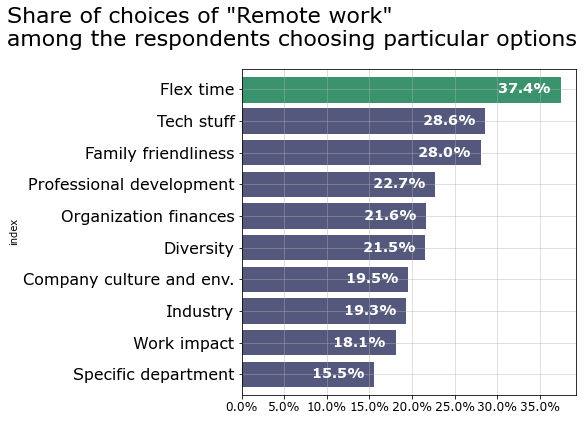

In [33]:
annot_params = {'va': 'center', 'ha': 'right', 'color': 'white', 'fontsize': 14, 'weight': 'bold'}

def plot_option(option: str, hl: List[int]=None, hc: str=C_GREEN):
    '''Plot the share of choices of given option among the respondents choosing other options.
    
    Parameters:
        - option: str, shortname of factor
        - hl: list of int, highlight, index of bar (counted from bottom and from 0)
        - hc: str, default C_GREEN, highlight color of bar bars with indexes stored in hl'''
    
    title = f'Share of choices of "{option}"\namong the respondents choosing particular options'
    option_data = rel_counts[option].drop(option).sort_values()
    plt.figure(**BARH_FIGURE_PARAMS)
    plt.yticks(fontsize=16)
    ax = option_data.plot.barh(width=0.8)
    ax.set_title(title, fontdict={'fontsize':22}, loc='left', x=-0.7, y=1.05)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))
    
    # Highlight the bars:
    if len(hl):
        for i in hl:
            ax.get_children()[i].set_color(hc)
    
    # Add annotations:
    for i, counter_option in enumerate(option_data.index):
        x = option_data[counter_option]
        ax.annotate(s=f'{x:.1f}%  ', xy=(x, i), **annot_params);
        
plot_option('Remote work', hl=[9])

Actually, we should expect this, because both questions are related to each other. Both are related to time of working. We can assume that the group of developers chosing these option consists of persons that requires convenience and comfort regarding the work time organization.

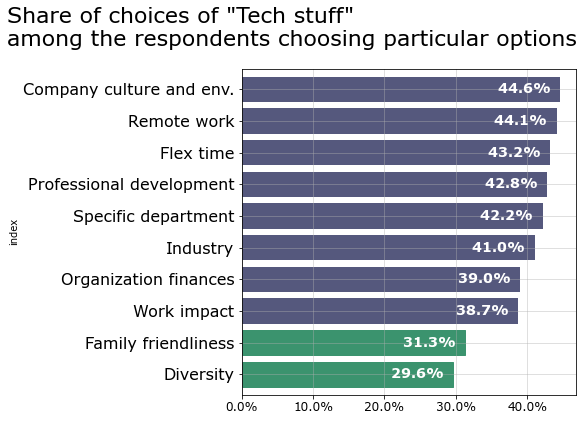

In [34]:
plot_option('Tech stuff', hl=[0,1])

Next interesting observation - it seems like "Tech stuff" is less important for individuals chosing "Family friendliness" or "Diversity". For this group the soft factors may be more relevant when choosing job.

Probably the better way to visualize these is to use devation from the mean:

In [35]:
def plot_feature_mean_dev(option, hl: List[int]=None, hc: str=C_GREEN, standardize=False):
    '''Plot the share of choices of given option among 
    the respondents choosing other options as a deviation from the mean
    
    Parameters:
        - option: str, shortname of factor
        - hl: list of int, highlight, index of bar (counted from bottom and from 0)
        - hc: str, default C_GREEN, highlight color of bar bars with indexes stored in hl
        - standardize: bool, default False, if plot the standardized values'''
    
    mean = rel_counts[option].mean()
    mean_dev = rel_counts[option].drop(option).sort_values() - mean
    title = f'Share of choices of "{option}"\namong the respondents choosing particular options\n(deviation from the mean; mean={mean:.1f}%)'
    
    if standardize:
        std = rel_counts[option].std()
        mean_dev /= std
        title = f'Standardized share of choices of "{option}"\namong the respondents choosing particular options'
    
    lim = abs(mean_dev).max()
    ax = mean_dev.plot.barh(width=0.7, figsize=(6,6))
    ax.set_title(title, fontdict={'fontsize':22}, loc='left',x=-1, y=1.05)
    plt.yticks(fontsize=16)
    if not standardize:
        ax.xaxis.set_major_formatter(mtick.PercentFormatter(100))
        
    ax.set_xlim((-lim, lim))
    
    if hl:
        for i in hl:
            ax.get_children()[i].set_color(hc);
            
    for i, counter_option in enumerate(mean_dev.index):
        x = mean_dev[counter_option]
        
        annotation = f'{x:.1f}'
        if not standardize:
            annotation += '% '
        if x < 0:
            ax.annotate(s=annotation, xy=(x+1/3*lim, i), **annot_params)
        else:
            ax.annotate(s=annotation, xy=(x, i), **annot_params)
        
    return ax

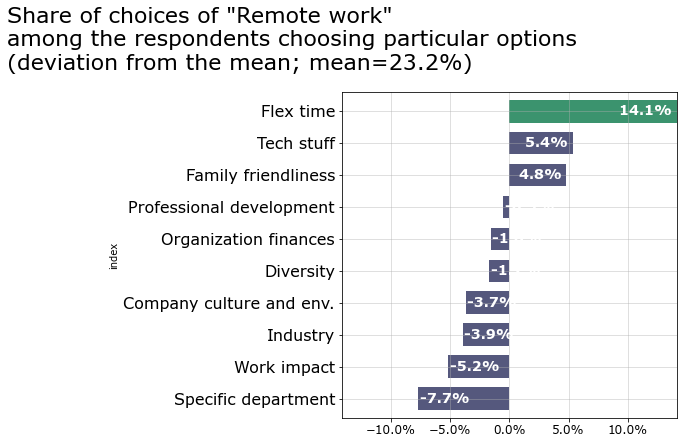

In [36]:
plot_feature_mean_dev('Remote work', hl=[9]);

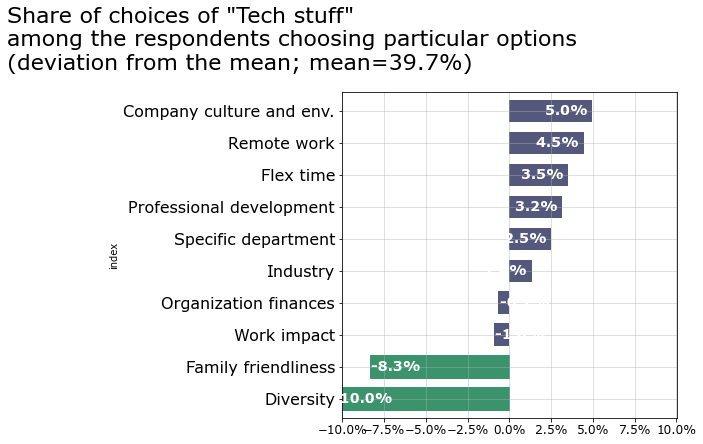

In [37]:
plot_feature_mean_dev('Tech stuff', hl=[0,1]);

Now we can clearly see how much each category differs from the average.

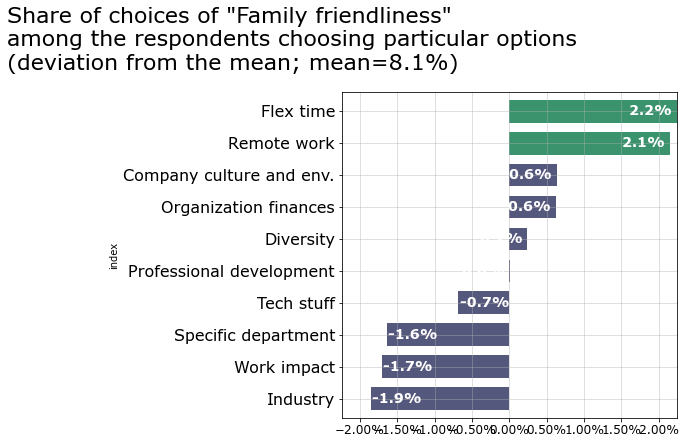

In [38]:
plot_feature_mean_dev('Family friendliness', hl=[8,9]);

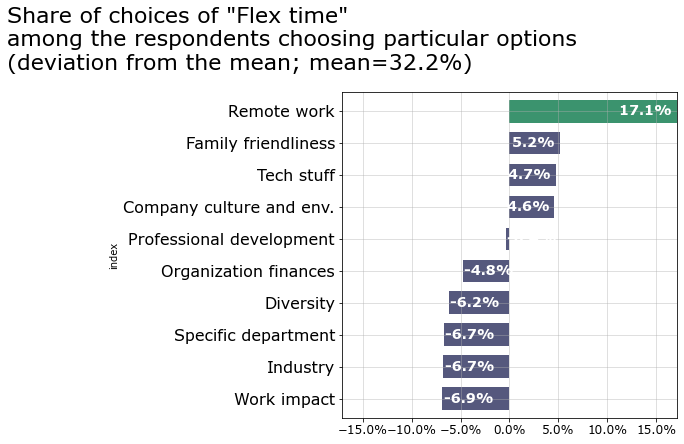

In [39]:
plot_feature_mean_dev('Flex time', hl=[9]);

We identified some values that stands out from each other. However how can we compare max deviations (green bars) from above charts between each other? Deviation of 17.1% seems to be more important that 2.2%. However it depends of two simple features of the examinated samples: 1) Mean 2) Standard deviation. As we can see, the means differs much between aboves metrics. The size of deviation of the means cold be corelated with the mean. We can easyli check that in three different ways: scatter plot, Pearson's Correlation Coefficient and Spearmann's Correlation Coefficient. The calculations involves means from each option and its standard deviation:

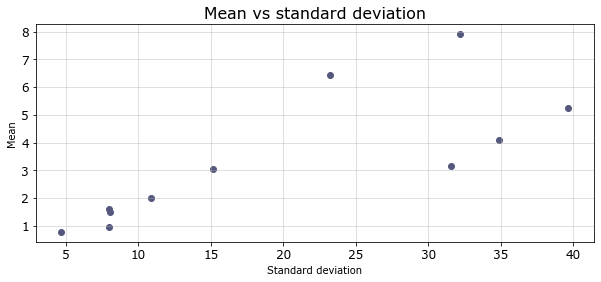

In [40]:
means = rel_counts.mean(axis=0)
stds = rel_counts.std(axis=0)

plt.scatter(means, stds)
plt.xlabel('Standard deviation')
plt.ylabel('Mean')
plt.title('Mean vs standard deviation');

We can easily observe there is a relation between the standard deviation and the mean. Let's confirm this using correlation coefficients.

In [41]:
pc, pc_pval = pearsonr(stds, means)
sc, sc_pval = spearmanr(stds, means)

print('COEF TYPE\tcoef\tp-value')
print(f'PEARSON:\t{pc:.2f}\t{pc_pval:.4f}\nSPEARMANN:\t{sc:.2f}\t{sc_pval:.4f}')

COEF TYPE	coef	p-value
PEARSON:	0.78	0.0048
SPEARMANN:	0.87	0.0005


Both monothonic and linear coefficients told us there is a correlation. 

In order to be able to compare the results between options samples, let's standardize them using following formula:

$$z_{ij} = \frac{x_{ij} - \overline{x_j}}{s_j}$$

Where: 

$x_{ij}$ - share of $j$ factor choices among $i$ group of respondents

$\overline{x_j}$ - average share of $j$ factor choices

$s$ - standard deviation of share of $j$ factor choices

In [ ]:
standardized = (rel_counts - means) / stds # standardization

# Heatmap of standardized values:
cm = sns.diverging_palette(10, 150, s=80, l=55, n=7)
plt.figure(figsize=(10,9), dpi=72)
ax = sns.heatmap(standardized, cmap=cm, center=0, annot=True,fmt='.1f', annot_kws={'fontsize':12})
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title('Standardized share of choices among the respondents\nchoosing particular options', fontsize=20, loc='left', x=-0.6, y=1.04)
plt.tight_layout();

Now we can see which options differs much from the global average which is equal to 0. For instance, let's track the share of those who picked "Company culture" among the respondents who chose the "Remote work options". The heatmap value of -2.1 suggests that this group differs the most the local average among all the other combinations of "Company culture" factor.

In [ ]:
plot_feature_mean_dev('Company culture and env.', hl=[0], standardize=True);

Now we can clearly see that for individuals who chose "Remote work options", it is more likely that the company culture would be less important than for others individuals.

**How about showing these outstanding relations using a graph?**

In [ ]:
standardized.sample(2)

In [ ]:
# Graphs
# networkx requires special data structure like:
# (X_node, Y_node, weight)
# Nodes are the indexes/columns names, weight is an absolute, standardized value.
# That's why I need to melt dataset as well as remove nans:
st_m = standardized.reset_index().melt('index').dropna() 

# Let's keep only edges of over standard deviation weight:
st_m = st_m.query('value > 1 | value < -1').reset_index(drop=True)
st_m['abs_value'] = st_m['value'].apply(abs)

# Create figure and multi directed graph (to keep two sided relations)
plt.figure(figsize=(12,7), constrained_layout=True)
plt.gcf().subplots_adjust(right=1)
G = nx.from_pandas_edgelist(st_m, 
                            source='index', 
                            target='variable', 
                            edge_attr=['value','abs_value'], 
                            create_using=nx.MultiDiGraph,
                            edge_key='abs_value')

# I would like to assign a color to distinguish negative and positive standardized values:
pos_edges = []
pos_values = []

neg_edges = []
neg_values = []

colors = []
node_names=dict()

for (u, v, attrib_dict) in list(G.edges.data()):
    node_names[u] = u
    
    if attrib_dict['value'] < 0:
        c = 'r'
        neg_edges.append((u,v))
        neg_values.append(attrib_dict['abs_value'])
    else:
        c = 'g'
        pos_edges.append((u,v))
        pos_values.append(attrib_dict['abs_value'])
    colors.append(c)
    
# Apply circular layout and obtain the coordinates in order to manipulate label locations:
pos = nx.circular_layout(G)
options = {"node_size": 800}
nx.draw_networkx_nodes(G, pos,  node_color="#55587d", **options)

edges_kwargs = {
    'G':G,
    'pos':pos,
    'alpha':0.4,
    'arrowsize':0.1
}

edges_kwargs_2 = {
    'G':G,
    'pos':pos,
    'arrowsize':40,
    'width':1.5
}

POWER = 4

nx.draw_networkx_edges(
    edgelist=neg_edges,
    width=np.power(neg_values, POWER),
    edge_color=C_RED,
    **edges_kwargs
)

nx.draw_networkx_edges(
    edgelist=pos_edges,
    width=np.power(pos_values, POWER),
    edge_color=C_GREEN,
    **edges_kwargs
)

nx.draw_networkx_edges(edgelist=neg_edges, edge_color=C_RED, **edges_kwargs_2)
nx.draw_networkx_edges(edgelist=pos_edges, edge_color=C_GREEN, **edges_kwargs_2)

pos_higher = {}

for k, v in pos.items():
    if v[1] > 0:
        y = v[1] + 0.16
    else:
        y = v[1] - 0.14
    
    if v[0] > 0.90:
        x = v[0] - 0.1
    elif v[0] < -0.9:
        x = v[0] + 0.1
    else:
        x = v[0]
    pos_higher[k] = (x, y)
        
nx.draw_networkx_labels(G, pos_higher, node_names, font_size=20, font_color='#55587d')
plt.axis("off")

plt.title('What factors are tended to be chosen together?', fontsize=20, y=1.1, loc='left')
custom_lines = [Line2D([0], [0], color=C_GREEN, lw=4),
                Line2D([0], [0], color=C_RED, lw=4)]

plt.legend(custom_lines, 
           ['More often than average', 'Less often than average'], 
           bbox_to_anchor=(0.0,0.56,0.6,0.56), 
           frameon=False, 
           fontsize=14, 
           ncol=2)

plt.show();

The relations are limited to only those over the standard deviation. 

There is a couple of insights here:
* Individuals that pick “Family friendliness” tend to care less about career-related factors. They are less likely to pick at least one of the following: “Specific department”, “Tech stuff”, “Professional development”, and “Industry ”.

* As a contrary to above, those who picked “Work impact”, are more likely to pick also “Industry” or “Professional development”.

* Those who picked “Diversity ” tend to care more about company culture and office environment, while less about “Organization finance” and “Tech stuff”. Actually, that's what we expected since diversity and inclusion are the important values of many companies.

* Last but not least, we can observe some similarities between “Flex time” and “Remote work options”. The group of developers choosing these options could consist of persons that require convenience and comfort regarding the work time organization. Respondents choosing these two are overlapping much, that’s why “Family friendliness” occurs in both as the factor they tend to chose more likely, while they both less often care about their impact on the reality, which confirms the hypothesis ‘Convenience first’.

We may ask which group of individuals differs the most from the average in terms of all job factors. To get the answer we could use the standarized features. Recall that the further from 0 the value is, there is a greater deviation from the average. Hence, we can sum up or calculate the average of absolute standardized values in order to get the group that stands out the most from the global average.

In [ ]:
standardized_abs = abs(standardized)
cm = sns.color_palette("dark:salmon_r", as_cmap=True)
plt.figure(figsize=(12,7))
ax = sns.heatmap(standardized_abs, cmap=cm, annot=True)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.title('Absolute standardized percentage of responses coexisting with another', fontsize=20, x=0.5, y=1.04)
plt.tight_layout();

In [ ]:
standardized_abs.mean(axis=1).sort_values().plot.barh(title='Average standardized share of responses');

As we can see "Remote work options" differs the most from the global average.

However what impacts on chosing this or that feature? There is multiple ways of answering the questions. Since the multiple options could be marked by individuals I'm going to treat each feature separately. So, it is possible to create multiple models of logistic regression as well as use artificial neural network. In this case I would like to use decision tree based algorithms since they perform better than logistic regression and the results are easier to interpret than the black box models.

Among the decision tree based models there is many possibilities. Random Forest, XGBoost, Light GBM, Cat Boost are just examples of such methods. Cat Boost is great choice when dealing with categorical features, however it is less explainable since the categoricals are transformed into the numeric features. Eventually I decided to use XGBoost.

Before we create the model, there should be prepared dataset. So let's back to our two dataframes: 
* `jobfactors_stack`, containing separated `JobFactors` and 
* `data` having data for all respondents. 

Notice that in the first one respondents are duplicated.

In [ ]:
jobfactors_stack.sample(2)

In [ ]:
data.sample()

In [ ]:
data.set_index('Respondent', inplace=True)
data.drop('JobFactors', axis=1, inplace=True)
jf_dataset = jobfactors_stack.merge(data, how='left', on='Respondent')

In [ ]:
jf_dataset.sample()

Since now, we have job factors assinged to data of each respondent and it is to time for data cleaning and preparation to modelling.

I'm going to add continent information to the dataset - I'll use continent as a feature:

In [ ]:
countries = pd.read_csv('https://raw.githubusercontent.com/dbouquin/IS_608/master/NanosatDB_munging/Countries-Continents.csv')
countries.replace('US', 'United States', inplace=True)
countries.replace('CZ', 'Czech Republic', inplace=True)
countries.replace('Congo, Democratic Republic of', 'Congo, Republic of the...', inplace=True)

countries[countries['Country'].str.startswith('Congo')]

In [ ]:
jf_dataset = jf_dataset.reset_index().merge(countries, how='left', on='Country').set_index('Respondent')
jf_dataset[jf_dataset.Continent.isna()]['Country'].unique()

There are still missing continents for some countries - data is inconsistent. For now let's leave it as it is. Let's clean the data and simplify.

In [ ]:
# Some continueas features contains non-continues values like strings:
cont_mapping_dict = {
    'YearsCode': {
        'Less than 1 year': 0,
        'More than 50 years': 51
    },
    'Age1stCode':{
        'Younger than 5 years': 4,
        'Older than 85': 86
    }
}

# Abbreviations would make it easier to print and read many feature names.
categ_mapping_dict = {
    'Employment': {
        'Employed full-time': 'EFT',
        'Student': 'ST',
        'Independent contractor, freelancer, or self-employed': 'F',
        'Not employed, but looking for work': 'NE',
        'Employed part-time': 'EPT'    
    },
    'MainBranch': {
        'I am a developer by profession': 'DEV',
        'I am a student who is learning to code': 'ST',
        'I am not primarily a developer, but I write code sometimes as part of my work': 'NDEV'
    },
    'Hobbyist': { 'Yes': 1, 'No': 0 },
    'EdLevel': {
        'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 'BCH',
        'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 'MS',
        'Some college/university study without earning a degree': 'ND',
        'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 'SS',
        'Associate degree (A.A., A.S., etc.)': 'AD',
        'Other doctoral degree (Ph.D., Ed.D., etc.)': 'PHD',
        'Professional degree (JD, MD, etc.)': 'PD',
        'Primary/elementary school': 'O',
        'I never completed any formal education': 'O'
    },
    'JobSat': {
        'Very satisfied': 'VS',
        'Slightly satisfied': 'SS',
        'Slightly dissatisfied': 'SD',
        'Very dissatisfied': 'VD',
        'Neither satisfied nor dissatisfied': 'NEUTRAL'
    },
    'JobFactors': {
        'Languages, frameworks, and other technologies I’d be working with': 'LANG',
        'Office environment or company culture': 'CULTURE',
        'Flex time or a flexible schedule': 'FLEX',
        'Opportunities for professional development': 'DEV',
        'Remote work options': 'REMOTE',
        'How widely used or impactful my work output would be': 'IMPACT',
        'Industry that I’d be working in': 'IND',
        'Family friendliness': 'FAMILY',
        'Financial performance or funding status of the company or organization': 'COMP_FIN',
        'Specific department or team I’d be working on': 'TEAM',
        'Diversity of the company or organization': 'DIVERSITY'
    },
    
    # Since there are really little number of respondents of given Genders and Sexualities, 
    # I decided to simplify the data. 
    'Gender': {
        'Non-binary, genderqueer, or gender non-conforming': 'OTHER',
        'Man;Non-binary, genderqueer, or gender non-conforming': 'OTHER',
        'Woman;Non-binary, genderqueer, or gender non-conforming': 'OTHER',
        'Woman;Man': 'OTHER',
        'Woman;Man;Non-binary, genderqueer, or gender non-conforming': 'OTHER'
    },
    'Sexuality': {
        'Straight / Heterosexual': 'HETERO',
        'Bisexual': 'BI',
        'Gay or Lesbian': 'GL',
        'Queer': 'OTHER',
        'Bisexual;Straight / Heterosexual' : 'OTHER', 
        'Bisexual;Queer': 'OTHER',
        'Gay or Lesbian;Queer': 'OTHER',
        'Bisexual;Gay or Lesbian;Straight / Heterosexual;Queer': 'OTHER',
        'Bisexual;Straight / Heterosexual;Queer': 'OTHER',
        'Straight / Heterosexual;Queer': 'OTHER',
        'Bisexual;Gay or Lesbian;Straight / Heterosexual': 'OTHER',
        'Gay or Lesbian;Straight / Heterosexual': 'OTHER',
        'Bisexual;Gay or Lesbian': 'OTHER', 
        'Bisexual;Gay or Lesbian;Queer': 'OTHER'
    },
    'JobSeek': {
       'I am not interested in new job opportunities': 'NOT',
       'I’m not actively looking, but I am open to new opportunities': 'OPEN',
       'I am actively looking for a job': 'YES'
    },
    'NEWOvertime': {
        'Often: 1-2 days per week or more': 'OFTEN',
        'Occasionally: 1-2 days per quarter but less than monthly':'OCCASION',
        'Never': 'NEVER',
        'Rarely: 1-2 days per year or less': 'RARELY',
        'Sometimes: 1-2 days per month but less than weekly': 'SOMETIMES'
    }
}

# These features aren't processed yet.
not_processed = ['Age', 'ConvertedComp', 'Continent', 'Country', 'OrgSize']

features = list(categ_mapping_dict.keys()) + list(cont_mapping_dict.keys()) + not_processed

In [ ]:
dataset = jf_dataset.replace(cont_mapping_dict).replace(categ_mapping_dict)[features]
X = dataset.drop('JobFactors', axis=1).reset_index().drop_duplicates().set_index('Respondent')

In [ ]:
# Decision trees are able to highlight the nan values as well as identify what is the replacement for those.
# That's why I decided to replace nans by -1. 
# Another approaches requires testing which choice would result in better modelling output.
X['YearsCode'] = X['YearsCode'].fillna(-1).astype(int)
X['Age1stCode'] = X['Age1stCode'].fillna(-1).astype(int)
X['Hobbyist'] = X['Hobbyist'].fillna(-1).astype(int)

X[X.select_dtypes('object').columns] = X[X.select_dtypes('object').columns].fillna('nan')

# Age:
X['Age'].fillna(value=X['YearsCode']+X['Age1stCode'], inplace=True)
X.loc[ X['Age'] < 0, 'Age'] = -1
X['Age'] = X['Age'].astype(int)

# Compensation:
X['ConvertedComp'] = X['ConvertedComp'].fillna(-1).astype(int)

In [ ]:
ax = X['ConvertedComp'].hist(bins=200)
ticks = ticker.FuncFormatter(lambda x, pos: '{0:.0f}k $'.format(x/1000))
ax.xaxis.set_major_formatter(ticks)
ax.set_title('Annual compensation of respondents');

In [ ]:
cat_features_indices = list(X.select_dtypes('object'))
cat_features_indices

Each JobFactor is considered as a separate target. It's not a multiclassification problem since the classes are overlapping. In this case, it seems like it is better to treat each class separately and provide a model for each of them.

In [ ]:
target_dummies = pd.get_dummies(dataset['JobFactors'])
target_dummies = target_dummies.reset_index().groupby('Respondent').max()
target_dummies.head(2)

# Modelling

In [ ]:
def train_and_predict_xgb(X, target: str, info: str, depth=10, n_estimators=2000, learning_rate=0.02):
    print(f'MODELLING:\t{target}\t{info}')
    xgb_X = pd.get_dummies(X)
    y = target_dummies[[target]]
    X_train, X_test, y_train, y_test = train_test_split(xgb_X, y, test_size=0.3)
    print(f'The shape of the training set: {X_train.shape}')
    xgb_model = xgb.XGBClassifier(booster='gbtree',
                                  max_depth=depth,
                                  n_estimators=n_estimators, 
                                  learning_rate=learning_rate, 
                                  verbosity=1,
                            
                                 )
    # train the model
    xgb_model.fit(X_train, y_train, verbose=100, 
                  eval_metric=['auc', 'map'], 
                  eval_set=[(X_train, y_train), (X_test, y_test)], 
                  early_stopping_rounds=600)
    
    y_pred_test = xgb_model.predict(X_test)
    y_pred_train = xgb_model.predict(X_train)
    print('Accuracy test\n:', accuracy_score(y_test, y_pred_test))
    print('Accuracy train\n:', accuracy_score(y_train, y_pred_train))
    return xgb_model, y_test, y_pred_test

In [ ]:
xgbm, y_test, y_pred_test = train_and_predict_xgb(X,'DIVERSITY', 'xgb first model', depth=5)

In [ ]:
xgbm, y_test, y_pred_test = train_and_predict_xgb(X,'DIVERSITY', 'xgb first model', depth=7)

In [ ]:
xgbm, y_test, y_pred_test = train_and_predict_xgb(X,'DIVERSITY', 'xgb first model', depth=4)

In [ ]:
xgbm2, y_test2, y_pred_test2 = train_and_predict_xgb(X,'FLEX', 'xgb first model', depth=10)

In [ ]:
xgbm2, y_test2, y_pred_test2 = train_and_predict_xgb(X,'FLEX', 'xgb first model', depth=7)

In [ ]:
def train_and_predict(X, target: str, cat_features, info: str, depth=8):
    print(f'MODELLING:\t{target}\t{info}')
    
    y = target_dummies[[target]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    pool_train = Pool(X_train, y_train, cat_features=cat_features, has_header=True)
    pool_test = Pool(X_test, y_test, cat_features=cat_features, has_header=True)
    
    model = CatBoostClassifier(iterations=2000,
                               depth=depth,
                               learning_rate=0.01,
                               loss_function='Logloss',
                               verbose=200,
                               nan_mode="Max",
                               eval_metric='AUC',
                               early_stopping_rounds=600,
                               min_data_in_leaf=10,
                               custom_metric=['Logloss', 'AUC']
                              )
    # train the model
    model.fit(pool_train, eval_set=pool_test,plot=True)
    preds_class = model.predict(X_test)
    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Accuracy test\n:', accuracy_score(y_test, y_pred_test))
    print('Accuracy train\n:', accuracy_score(y_train, y_pred_train))
    
    return model, preds_class

In [ ]:
results = dict()

In [ ]:
def training_to_results(target, cat_features_indices=cat_features_indices, info='ConvertedComp included + NEWOvertime + JobSeek'):
    results[target] = train_and_predict(X, target, cat_features_indices, info=info)

In [ ]:
xgb_results = dict()
def training_to_results_xgb(target, info='ConvertedComp included + NEWOvertime + JobSeek', depth=10, n_estimators=2000,lr=0.02):
    xgb_results[target] = train_and_predict_xgb(X, 
                                            target, 
                                            info=info, 
                                            depth=depth, 
                                            n_estimators=n_estimators, 
                                            learning_rate=lr)
    

In [ ]:
xgb_results

In [ ]:
for target in ('REMOTE', 'FLEX', 'DIVERSITY'):
    training_to_results_xgb(target=target)

In [ ]:
target = 'REMOTE'
model, preds_class = train_and_predict(X, 'REMOTE', cat_features_indices, info='ConvertedComp included + NEWOvertime + JobSeek')

In [ ]:
model2, preds_class2 = train_and_predict(X, 'FLEX', cat_features_indices, info='ConvertedComp included + NEWOvertime + JobSeek')

In [ ]:
# model3, preds_class3 = train_and_predict(X, 'DIVERSITY', cat_features_indices, info='ConvertedComp included + NEWOvertime + JobSeek')

In [ ]:
# model4, preds_class4 = train_and_predict(X, 'REMOTE', cat_features_indices, info='ConvertedComp, Age,  included')

In [ ]:
model.get_feature_importance(prettified=True).plot.barh(x='Feature Id', y='Importances');

In [ ]:
model.get_feature_importance(prettified=True).plot.barh(x='Feature Id', y='Importances');

In [ ]:
model.get_feature_importance(prettified=True).plot.barh(x='Feature Id', y='Importances');

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(xgb_results['DIVERSITY'][0])
xgb_X = pd.get_dummies(X)
shap_values = explainer.shap_values(xgb_X)

In [ ]:
shap.summary_plot(shap_values, xgb_X, feature_names=xgb_X.columns)

In [ ]:
i = np.random.randint(0, X.shape[0])
shap.force_plot(explainer.expected_value, shap_values[4,:], X.iloc[4,:])

In [ ]:
shap_values

In [ ]:
shap_values = explainer.shap_values(X_test)

# Make plot. Index of [1] is explained in text below.
shap.summary_plot(shap_values, X_test)

In [ ]:
explainer.expected_value